# Data and Library Imports


In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.7 MB/s eta 0:00:00


In [2]:
from IPython import get_ipython
from IPython.display import display

In [3]:
import rasterio
from rasterio.enums import Resampling
from rasterio.features import rasterize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import folium.plugins
from sklearn.metrics import accuracy_score
import geopandas as gpd
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/ENGO_645/ENGO_645_Project_W2025/

/content/drive/MyDrive/ENGO_645/ENGO_645_Project_W2025


#Train Test Split

In [35]:
tif_files_and_Geophys = [
    'Data/Soil_Geochem/Soil_IDW_Ag/Soil_IDW_Ag.tif',  #Silver
    'Data/Soil_Geochem/Soil_IDW_As/Soil_IDW_As.tif',  #Arsenic
    'Data/Soil_Geochem/Soil_IDW_Al/Soil_IDW_Al.tif',  #Aluminum
    'Data/Soil_Geochem/Soil_IDW_Co/Soil_IDW_Co.tif',  #Cobalt
    'Data/Soil_Geochem/Soil_IDW_Bi/Soil_IDW_Bi.tif',  #Bismuth
    'Data/Soil_Geochem/Soil_IDW_Cu/Soil_IDW_Cu.tif',  #Copper
    'Data/Soil_Geochem/Soil_IDW_Au/Soil_IDW_Au.tif',  #Gold
    'Data/Soil_Geochem/Soil_IDW_Zn/Soil_IDW_Zn.tif',  #Zinc
    'Data/Soil_Geochem/Soil_IDW_Pb/Soil_IDW_Pb.tif',  #Lead
    'Data/Soil_Geochem/Soil_IDW_Ni/Soil_IDW_Ni.tif',  #Nickel
    'Data/Soil_Geochem/Soil_IDW_Mo/Soil_IDW_Mo.tif',  #Molybdenum
    'Data/Soil_Geochem/Soil_IDW_W/Soil_IDW_W.tif',    #Tungsten
    'Data/Soil_Geochem/Soil_IDW_Hg/Soil_IDW_Hg.tif',  #Mercury
    'Data/Soil_Geochem/Soil_IDW_Sn/Soil_IDW_Sn.tif',  #Tin
    'Data/Soil_Geochem/Soil_IDW_Sb/Soil_IDW_Sb.tif',  #Antimony
    'Data/Soil_Geochem/Soil_IDW_Te/Soil_IDW_Te.tif',  #Tellurium
    'Data/Geophysical_Anomaly/GeoPhysAnomaly_DONE.tif'
]

In [36]:
#setting label or target of model
with rasterio.open("Data/Gold_Litho/Litho_Gold.tif") as src:
    gold_labels = src.read(1)
    transform = src.transform
    gold_labels = (gold_labels - np.min(gold_labels)) / (np.max(gold_labels) - np.min(gold_labels))  #Normalize 0-1

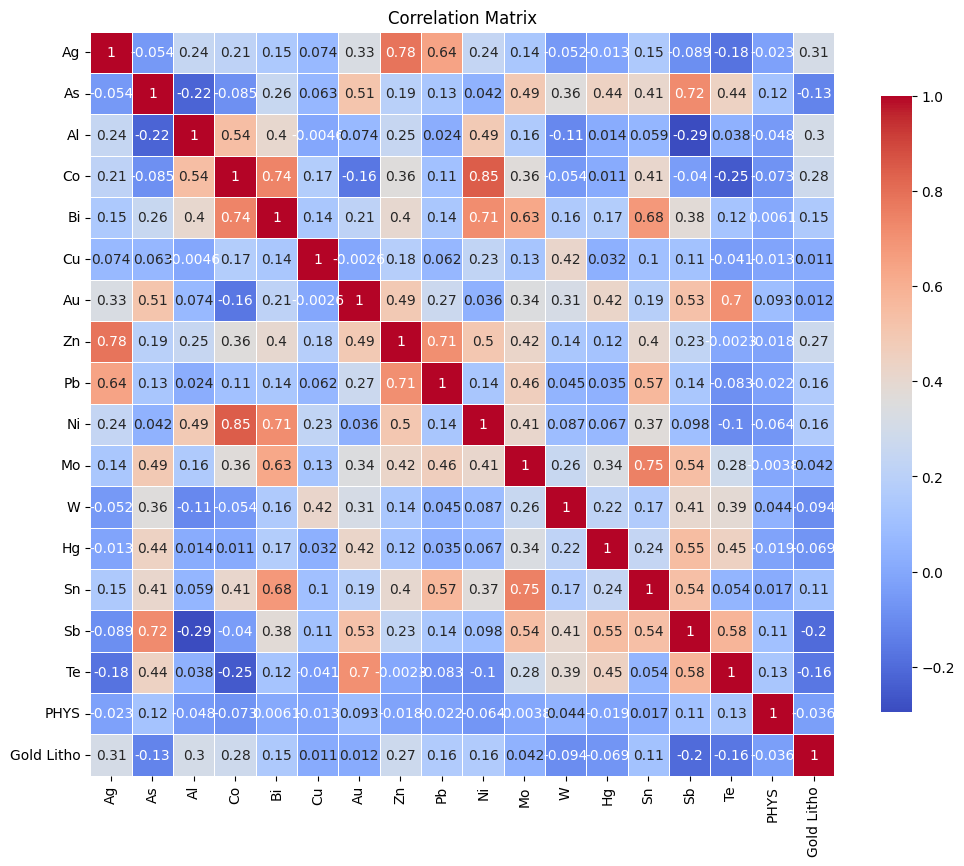

In [37]:
num_rasters = len(tif_files_and_Geophys)
raster_data = []

# Flatten each raster and append to the list
for i in range(num_rasters):
    with rasterio.open(tif_files_and_Geophys[i]) as src:
        data = src.read(1).flatten()
        raster_data.append(data)

#Create a DataFrame from flattened raster data and gold raster data
df = pd.DataFrame(raster_data).T
df['Gold_Litho'] = gold_labels.flatten()
# Calculate correlation matrix
correlation_matrix = df.corr()

element_names = ['Ag', 'As', 'Al', 'Co', 'Bi', 'Cu', 'Au', 'Zn', 'Pb', 'Ni', 'Mo', 'W', 'Hg', 'Sn', 'Sb', 'Te', "PHYS", 'Gold Litho']
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            square=True,
            cbar_kws={'shrink': .8},
            annot_kws={"size": 10},
            linewidths=.5,
            xticklabels=element_names,
            yticklabels=element_names)

plt.savefig('correlation_matrix.png')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#setting grid
cell_size = 0.005
width = src.width * transform.a
height = src.height * abs(transform.e)
xmin = transform.c
ymax = transform.f
xmax = xmin + width
ymin = ymax - height

#applying grid
x, y = np.meshgrid(np.arange(xmin, xmax, cell_size), np.arange(ymax, ymin, -cell_size))
x = x.flatten()
y = y.flatten()

grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x, y)
).buffer(cell_size / 2, cap_style=3)

#seperating training and testing set based on grid
n_samples = len(grid)

n_train = int(n_samples * (1 - 0.2))
n_test = n_samples - n_train

train_grid = grid.sample(n=n_train, random_state=42)
test_grid = grid.drop(train_grid.index)

train_mask = rasterize(
    shapes=train_grid.geometry,
    out_shape=gold_labels.shape[0:2],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

test_mask = rasterize(
    shapes=test_grid.geometry,
    out_shape=gold_labels.shape[0:2],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

train_labels = gold_labels.squeeze() * train_mask
test_labels = gold_labels.squeeze() * test_mask

train_features_list = []
test_features_list = []

for tif_file in tif_files_and_Geophys:
    with rasterio.open(tif_file) as src:
        data = src.read(1)
        data = (data - np.min(data)) / (np.max(data) - np.min(data))  #Normalize 0-1

        train_data = data * train_mask
        test_data = data * test_mask

        train_features_list.append(train_data)
        test_features_list.append(test_data)

train_features = np.stack(train_features_list, axis=-1)
test_features = np.stack(test_features_list, axis=-1)

In [ ]:
#reshape for inputs
train_features = train_features.reshape(1, train_features.shape[0], train_features.shape[1], train_features.shape[2])
train_labels = train_labels.reshape(1, train_labels.shape[0], train_labels.shape[1], 1)
test_features = test_features.reshape(1, test_features.shape[0], test_features.shape[1], test_features.shape[2])
test_labels = test_labels.reshape(1, test_labels.shape[0], test_labels.shape[1], 1)

#model and convolution layer design
model = Sequential([
       Input(shape=(train_features.shape[1], train_features.shape[2], train_features.shape[3])),
       Conv2D(32, (3, 3), activation="relu", padding='same'),
       Dropout(0.2),
       Conv2D(64, (3, 3), activation="relu", padding='same'),
       Dropout(0.2),
       Conv2D(1, (3,3), activation='sigmoid', padding='same')
   ])

#compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

model.fit(train_features, train_labels, epochs=15, validation_data=(test_features, test_labels))

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2945 - loss: 0.6599 - val_accuracy: 0.8314 - val_loss: 0.6573
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3206 - loss: 0.6189 - val_accuracy: 0.8324 - val_loss: 0.6344
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3213 - loss: 0.5747 - val_accuracy: 0.8324 - val_loss: 0.6088
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3213 - loss: 0.5267 - val_accuracy: 0.8324 - val_loss: 0.5801
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3213 - loss: 0.4748 - val_accuracy: 0.8324 - val_loss: 0.5477
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3213 - loss: 0.4205 - val_accuracy: 0.8324 - val_loss: 0.5118
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3213 - loss: 0.3656 - val_accuracy: 0.8324 - val_loss: 0.4724
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3213 - loss: 0.3135 - val_accuracy: 0.8324 - val_loss: 0.4305
Epoch 9/15
1/1 ━

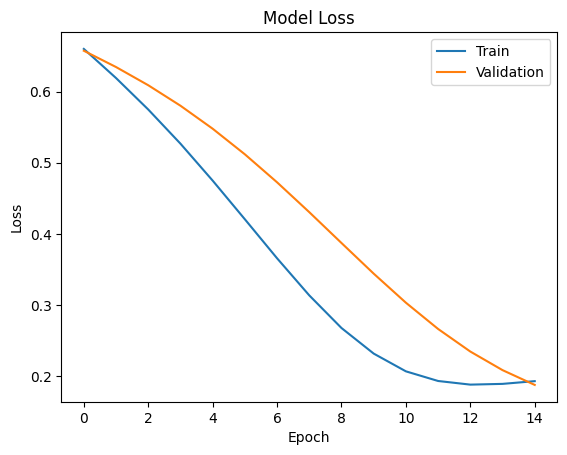

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

In [ ]:
#generating data from testing data
predictions = model.predict(test_features)
predictions = predictions.reshape(gold_labels.shape)
predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))  #Normalize

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


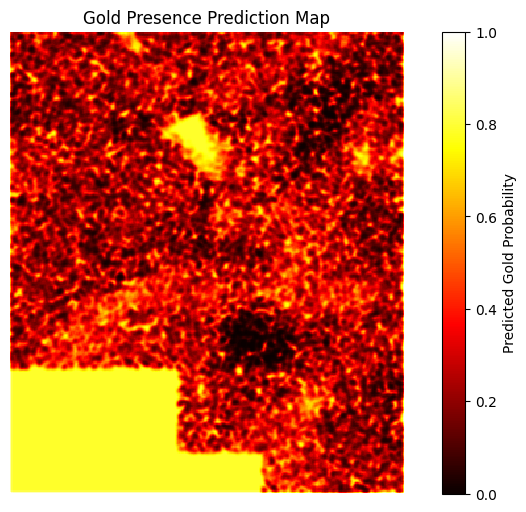

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(predictions, cmap="hot", interpolation="nearest")
plt.colorbar(label="Predicted Gold Probability")
plt.title("Gold Presence Prediction Map")
plt.axis("off")
plt.savefig('gold_presence_heatmap.png')
plt.show()

In [ ]:
#saving heatmap as raster for arc visualization
with rasterio.open(tif_files_and_Geophys[0]) as src:
    profile = src.profile

profile.update({
    'dtype': rasterio.float32,
    'count': 1
})

with rasterio.open("gold_presence_soil.tif", "w", **profile) as dst:
    dst.write(predictions.astype(rasterio.float32), 1)
print("Heatmap exported as gold_presence_heatmap.tif")

Heatmap exported as gold_presence_heatmap.tif


In [ ]:
accuracy = accuracy_score((test_labels.flatten() > 0.5).astype(int), (predictions.flatten() > 0.5).astype(int))
print("Accuracy:", accuracy)

Accuracy: 0.7846191959904334
